In [1]:
import sys
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import traci
from sumolib import checkBinary
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
import sys
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from collections import namedtuple, deque
import gym
from torch_geometric.utils import dense_to_sparse
import copy
from utils import *
from Models import *

if 'SUMO_HOME' in os.environ:
    print('SUMO_HOME found')
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

sumoBinary = checkBinary('sumo')
roadNetwork = "./config/osm.sumocfg"
sumoCmd = [sumoBinary, "-c", roadNetwork, "--start", "--quit-on-end"]
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

SUMO_HOME found
SUMO_HOME found
Using device: cuda


In [2]:
class RoutingGym(gym.Env):
    def __init__(self, sumoCmd, max_steps=1100, n_nodes=57, max_routing_steps=30):
        self.sumoCmd = sumoCmd
        self.step_counter = 0
        self.max_steps = max_steps
        self.n_nodes = n_nodes
        self.start_node = None
        self.end_node = None
        self.current_node = None
        self.node_features = None
        self.adj_matrix = None
        self.edge_index = None
        self.hop_thresh = None
        self.routing_done = False
        self.routing_steps = 0
        self.min_n_hops = None
        self.end_node_indicator = torch.zeros(n_nodes)
        self.max_routing_steps = max_routing_steps
        self.n_hop_matrix = None

    def reset(self):
        try:
            traci.close()
        except:
            pass
        traci.start(sumoCmd)
        self.step_counter = 0

        while self.step_counter < 400:
            traci.simulationStep()
            self.step_counter += 1
    
    def step(self):
        traci.simulationStep()
        self.step_counter += 1
        self.end_node_indicator = torch.zeros(self.n_nodes)
        self.routing_done = False
        self.routing_steps = 0
        self.adj_matrix, self.xs, self.ys = intervehicleConnectivity_xs_ys(800)
        self.adj_matrix = self.adj_matrix - torch.eye(self.adj_matrix.size(0))
        self.select_start_end_nodes()
        self.current_node = self.start_node
        self.adj_matrix = F.pad(self.adj_matrix, (0, self.n_nodes - self.adj_matrix.size(0), 0, self.n_nodes - self.adj_matrix.size(1)), "constant", 0)
        self.n_hop_matrix = F.pad(self.n_hop_matrix, (0, self.n_nodes - self.n_hop_matrix.size(0), 0, self.n_nodes - self.n_hop_matrix.size(1)), "constant", -100)
        self.n_hop_matrix = self.n_hop_matrix - torch.diag(torch.diag(self.n_hop_matrix))
        self.n_hop_matrix = self.n_hop_matrix - torch.diag(torch.diag(self.n_hop_matrix))
        self.edge_index, _ = dense_to_sparse(self.adj_matrix)
        curr_node_indicator = torch.zeros(self.n_nodes)
        curr_node_indicator[self.current_node] = 1
        self.end_node_indicator[self.end_node] = 1
        neighbour_indicator = self.adj_matrix[self.current_node]
        distances = self.n_hop_matrix[self.end_node]
        distances[distances == -100] = 8
        distances[distances > 7] = 7
        one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
        self.node_features = torch.cat((one_hot_distances, self.end_node_indicator.unsqueeze(1),
                                             curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1),
                                               self.norm_x, self.norm_y), dim=1).to(device)
        
        return self.node_features

    def refresh(self):
        self.end_node_indicator = torch.zeros(self.n_nodes)
        self.routing_done = False
        self.routing_steps = 0
        self.select_start_end_nodes(True)
        self.current_node = self.start_node
        self.edge_index, _ = dense_to_sparse(self.adj_matrix)
        curr_node_indicator = torch.zeros(self.n_nodes)
        curr_node_indicator[self.current_node] = 1
        self.end_node_indicator[self.end_node] = 1
        neighbour_indicator = self.adj_matrix[self.current_node]
        distances = self.n_hop_matrix[self.end_node]
        distances[distances == -100] = 8
        distances[distances > 7] = 7
        one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
        self.node_features = torch.cat((one_hot_distances, self.end_node_indicator.unsqueeze(1),
                                             curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1),
                                               self.norm_x, self.norm_y), dim=1).to(device)
        
        return self.node_features

    def select_start_end_nodes(self, refresh=False):
        if not refresh:
            self.n_hop_matrix = bfs_distance(self.adj_matrix)
        self.hop_thresh = min(self.n_hop_matrix.max(), 5)
        starts, ends = torch.where(self.hop_thresh == self.n_hop_matrix)
        starts = starts.tolist()
        ends = ends.tolist()
        self.start_node, self.end_node = random.choice(list(zip(starts, ends)))
        # minimal number of hops between start and end nodes
        self.min_n_hops = self.n_hop_matrix[self.start_node, self.end_node]

        start_x = self.xs[self.start_node]
        start_y = self.ys[self.start_node]
        end_x = self.xs[self.end_node]
        end_y = self.ys[self.end_node]
        self.norm_x = (self.xs - end_x) / (start_x - end_x)
        self.norm_y = (self.ys - end_y) / (start_y - end_y)
        self.norm_x = F.pad(self.norm_x, (0, 0, 0, self.n_nodes - self.norm_x.size(0)), "constant", 0)
        self.norm_y = F.pad(self.norm_y, (0, 0, 0, self.n_nodes - self.norm_y.size(0)), "constant", 0)

    def act(self, neighbor_index):
        self.routing_steps += 1
        neighbors = torch.where(self.adj_matrix[self.current_node] == 1)[0]
        valid_action_size = len(neighbors)
        if valid_action_size <= neighbor_index:
            self.routing_done = self.routing_steps >= self.max_routing_steps
            if self.routing_done:
                return self.node_features, torch.tensor(-1).to(device), True
            return self.node_features, torch.tensor(-0.15).to(device), False
        else:
            next_hop = neighbors[neighbor_index]
            reward = self.compute_reward(next_hop)
            self.current_node = next_hop
            curr_node_indicator = torch.zeros(self.n_nodes)
            curr_node_indicator[self.current_node] = 1
            neighbour_indicator = self.adj_matrix[self.current_node]
            distances = self.n_hop_matrix[self.end_node]
            distances[distances == -100] = 8
            distances[distances > 7] = 7
            one_hot_distances = F.one_hot(distances.long(), num_classes=8).type(torch.float32)
            self.node_features = torch.cat((one_hot_distances, self.end_node_indicator.unsqueeze(1),
                                             curr_node_indicator.unsqueeze(1), neighbour_indicator.unsqueeze(1),
                                               self.norm_x, self.norm_y), dim=1).to(device)
            return self.node_features, torch.tensor(reward).to(device), self.routing_done

    def get_action_mask(self):
        action_mask = copy.deepcopy(self.adj_matrix[self.current_node])
        action_mask = F.pad(action_mask, (0, self.n_nodes - action_mask.size(0)), "constant", 0).to(device)
        return action_mask

    def get_adj_matrix(self):
        return copy.deepcopy(self.adj_matrix).to(device)
    
    def get_edge_index(self):
        return copy.deepcopy(self.edge_index).to(device)
        
    def compute_reward(self, next_hop):
        if self.routing_steps >= self.max_routing_steps:
            # print("Failed, ", self.min_n_hops)
            self.routing_done = True
            return -1
        elif next_hop == self.end_node:
            # print("Routing done, number of hops: ", self.routing_steps, " minimum number of hops: ", self.min_n_hops)
            self.routing_done = True
            return (self.min_n_hops / self.routing_steps)
        elif self.n_hop_matrix[self.current_node, self.end_node] > self.n_hop_matrix[next_hop, self.end_node]:
            return 0.1
        else:
            return -0.15
        
    def sim_done(self):
        """
        function: get the done state of simulation.
        """
        return not (shouldContinueSim() and self.step_counter <= self.max_steps)

In [3]:
Transition = namedtuple('Transition',
                        ('data', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [4]:
BATCH_SIZE = 128
GAMMA = 0.9
GAMMA = 0.9
EPS_START = 0.2
EPS_END = 0.001
EPS_DECAY = 600
TAU = 0.005
LR = 0.001

def select_action(data, action_mask):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(data).max(1).indices.view(-1)
    else:
        valid_size = len(torch.where(action_mask == 1)[0])
        return torch.randint(0, valid_size, (1,), device=device)

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = Batch.from_data_list([s for s in batch.next_state
                                                if s is not None])
    data_batch = Batch.from_data_list(batch.data)
    action_batch = torch.stack(batch.action)
    reward_batch = torch.concat(batch.reward)
  
    state_action_values = policy_net(data_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [6]:
def train(iter=200):
    reward_history = []
    env.reset()
    episode_num = 0
    for step in range(100):
        state = env.step()
        for i in range(iter):
            state = env.refresh()
            episode_num += 1
            edge_index = env.get_edge_index()
            routing_done = False
            accumulated_reward = 0
            while not routing_done:
                action_mask = env.get_action_mask()
                data = Data(x=state, edge_index=edge_index)
                action = select_action(data, action_mask)
                node_features, reward, routing_done = env.act(action.item())
                reward = torch.tensor([reward], device=device)
                accumulated_reward += reward.item()

                routing_done = routing_done

                if routing_done:
                    next_state = None
                    memory.push(data, action, None, reward)
                else:
                    next_state = node_features
                    memory.push(data, action, Data(x=next_state, edge_index=edge_index), reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                optimize_model()

                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)
            reward_history.append(accumulated_reward)
            if episode_num % 100 == 0:
                print("Episode: ", episode_num, " Reward: ", accumulated_reward)
    return reward_history

In [7]:
env = RoutingGym(sumoCmd)
n_nodes = 57
policy_net = DQN(n_nodes=n_nodes).to(device)
target_net = DQN(n_nodes=n_nodes).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)
steps_done = 0

reward_history = train(200)

 Retrying in 1 seconds
***Starting server on port 54237 ***
Loading net-file from './config/osm.net.xml.gz' ... done (109ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_60135/1611129874.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.node_features, torch.tensor(reward).to(device), self.routing_done


Episode:  100  Reward:  -2.100000075995922
Episode:  200  Reward:  1.4000000059604645
Episode:  300  Reward:  1.4000000059604645
Episode:  400  Reward:  1.4000000059604645
Episode:  500  Reward:  -2.100000075995922
Episode:  600  Reward:  1.4000000059604645
Episode:  700  Reward:  -2.0576924085617065
Episode:  800  Reward:  1.0833333134651184
Episode:  900  Reward:  1.0833333134651184
Episode:  1000  Reward:  1.4000000059604645
Episode:  1100  Reward:  1.4000000059604645
Episode:  1200  Reward:  -1.3500000536441803
Episode:  1300  Reward:  1.4000000059604645
Episode:  1400  Reward:  -1.600000061094761
Episode:  1500  Reward:  1.4000000059604645
Episode:  1600  Reward:  1.064285732805729
Episode:  1700  Reward:  -1.600000061094761
Episode:  1800  Reward:  -5.100000165402889
Episode:  1900  Reward:  1.4000000059604645
Episode:  2000  Reward:  -5.35000017285347
Episode:  2100  Reward:  -2.100000075995922
Episode:  2200  Reward:  1.4000000059604645
Episode:  2300  Reward:  1.40000000596046

In [8]:
def test():
    env.reset()
    accumulated_rewards = []
    done = False
    while not done:
        state = env.step()
        edge_index = env.get_edge_index()
        done = env.sim_done()
        accumulated_reward = 0
        routing_done = False
        while not routing_done:
            action_mask = env.get_action_mask()
            data = Data(x=state, edge_index=edge_index)
            action = select_action(data, action_mask)
            node_features, reward, routing_done = env.act(action.item())
            reward = torch.tensor([reward], device=device)
            accumulated_reward += reward.item()

            routing_done = routing_done

            if routing_done:
                next_state = None
            else:
                next_state = node_features

            # Move to the next state
            state = next_state
        accumulated_rewards.append(accumulated_reward)
    return accumulated_rewards

In [9]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_dqn.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5925.61s
 TraCI-Duration: 3494.73s
 Real time factor: 0.0843796
 UPS: 2.134803
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 41481 ***
Loading net-file from './config/osm.net.xml.gz' ... done (111ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_60135/1611129874.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.node_features, torch.tensor(reward).to(device), self.routing_done


Average test reward:  -2.963054583879578


[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

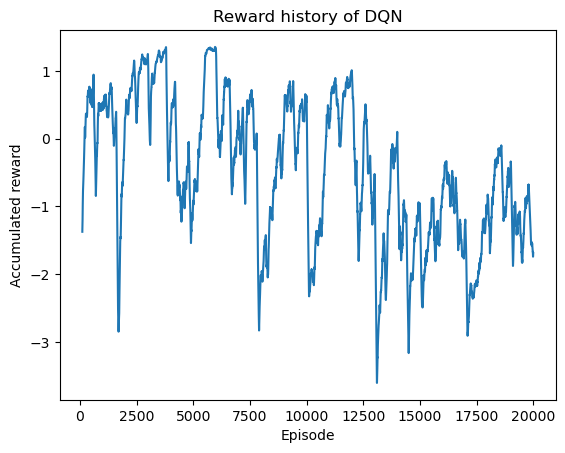

In [11]:
# save reward history
reward_history = pd.DataFrame(reward_history)
reward_history.to_csv('reward_history_dqn_iterate.csv', index=False)
# smooth the reward history
reward_history = reward_history.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(reward_history)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [12]:
env = RoutingGym(sumoCmd)

policy_net = GDQN(n_nodes=57).to(device)
target_net = GDQN(n_nodes=57).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000000)

steps_done = 0

reward_history = train(200)

Simulation ended at time: 1101.00
Reason: TraCI requested termination.
Performance: 
 Duration: 62.74s
 TraCI-Duration: 30.12s
 Real time factor: 17.5475
 UPS: 650.309193
Vehicles: 
 Inserted: 89
 Running: 30
 Waiting: 0
Statistics (avg of 59):
 RouteLength: 4182.20
 Speed: 9.57
 Duration: 445.32
 WaitingTime: 15.56
 TimeLoss: 61.37
 DepartDelay: 0.48

 Retrying in 1 seconds
***Starting server on port 55219 ***
Loading net-file from './config/osm.net.xml.gz' ... done (101ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_60135/1611129874.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.node_features, torch.tensor(reward).to(device), self.routing_done


Episode:  100  Reward:  -5.100000165402889
Episode:  200  Reward:  -4.3500001430511475
Episode:  300  Reward:  1.4000000059604645
Episode:  400  Reward:  -1.600000061094761
Episode:  500  Reward:  1.0833333134651184
Episode:  600  Reward:  -1.600000061094761
Episode:  700  Reward:  -5.100000165402889
Episode:  800  Reward:  1.4000000059604645
Episode:  900  Reward:  1.4000000059604645
Episode:  1000  Reward:  1.4000000059604645
Episode:  1100  Reward:  -0.991666741669178
Episode:  1200  Reward:  1.4000000059604645
Episode:  1300  Reward:  1.064285732805729
Episode:  1400  Reward:  0.8142857253551483
Episode:  1500  Reward:  0.8142857253551483
Episode:  1600  Reward:  1.0833333134651184
Episode:  1700  Reward:  -1.600000061094761
Episode:  1800  Reward:  -4.600000150501728
Episode:  1900  Reward:  0.8142857253551483
Episode:  2000  Reward:  1.4000000059604645
Episode:  2100  Reward:  0.8555555790662766
Episode:  2200  Reward:  0.3131578788161278
Episode:  2300  Reward:  -1.6000000610947

[Text(0.5, 0, 'Episode'),
 Text(0, 0.5, 'Accumulated reward'),
 Text(0.5, 1.0, 'Reward history of DQN')]

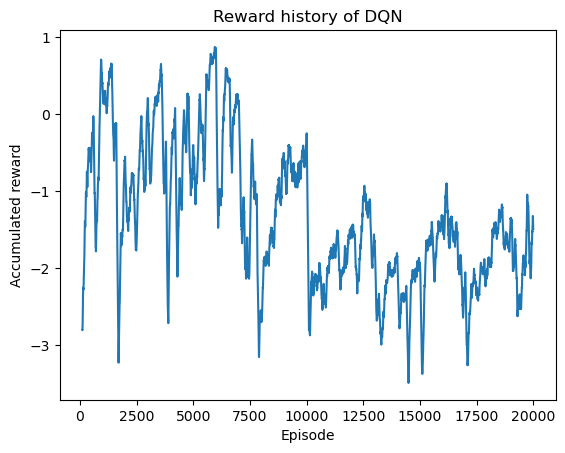

In [15]:
# save reward history
reward_history = pd.DataFrame(reward_history)
reward_history.to_csv('reward_history_gdqn_iterate.csv', index=False)
# smooth the reward history
reward_history = reward_history.rolling(window=100).mean()
fig, ax = plt.subplots()
ax.plot(reward_history)
ax.set(xlabel='Episode', ylabel='Accumulated reward',
       title='Reward history of DQN')

In [14]:
test_rewards = np.array(test())
# save the test rewards
np.save("test_rewards_gdqn.npy", test_rewards)
print("Average test reward: ", np.mean(test_rewards))

Simulation ended at time: 500.00
Reason: TraCI requested termination.
Performance: 
 Duration: 5565.81s
 TraCI-Duration: 5491.62s
 Real time factor: 0.0898342
 UPS: 2.272805
Vehicles: 
 Inserted: 55 (Loaded: 70)
 Running: 44
 Waiting: 0
Statistics (avg of 11):
 RouteLength: 2348.59
 Speed: 9.89
 Duration: 244.45
 WaitingTime: 5.91
 TimeLoss: 30.81
 DepartDelay: 0.41

 Retrying in 1 seconds
***Starting server on port 35611 ***
Loading net-file from './config/osm.net.xml.gz' ... done (105ms).
Loading done.
Simulation version 1.20.0 started with time: 0.00.


/tmp/ipykernel_60135/1611129874.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.node_features, torch.tensor(reward).to(device), self.routing_done


Average test reward:  -3.1556009513016434
